## Resources
- Allen B. Downey, *Think DSP: Digital Signal Processing in Python* [[website](http://greenteapress.com/wp/think-dsp/)] [[pdf](http://greenteapress.com/thinkdsp/thinkdsp.pdf)] [[github](http://greenteapress.com/wp/think-dsp/)]
- Allen B. Downey, *Basic Signal Processing in Python*, [YouTube video](https://youtu.be/0ALKGR0I5MA)

## Table of Contents
- [Basic Waves](#Basic-Waves)
- [Signal Comparisons](#Signal-Comparisons)
- [Noise and Smoothing](#Noise-and-Smoothing)
- [Fast Fourier Transforms (FFT)](#FFT)

In [9]:
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
import IPython.display as ipd # for playing sound https://ipython.org/ipython-doc/2/api/generated/IPython.lib.display.html#IPython.lib.display.Audio
import matplotlib as mpl


In [53]:
# Helper functions

# Plots a sine wave signal to axis
def plot_signal_to_axes(ax, s, sampling_rate, title=None, signal_label=None):
    ax.plot(s, label=signal_label)
    ax.set(xlabel="samples")
    
    if signal_label is not None:
        ax.legend()

    # we use y=1.14 to make room for the secondary x-axis
    # see: https://stackoverflow.com/questions/12750355/python-matplotlib-figure-title-overlaps-axes-label-when-using-twiny
    if title is not None:
        ax.set_title(title, y=1.3)
    
    ax.grid()

    # add in a secondary x-axis to draw the x ticks as time (rather than samples)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel("time (secs)")
    ax_ticks = ax.get_xticks()[1:-1]
    ax2_tick_labels = ax.get_xticks()[1:-1] / sampling_rate
    ax2_tick_labels = ['{:.2f}s'.format(x) for x in ax2_tick_labels]
    ax2.set_xticks(ax_ticks)
    ax2.set_xticklabels(ax2_tick_labels)
    
def plot_multiple_freq(freqs, signal_combined, map_freq_to_signal, sampling_rate):
    n_rows = len(freqs) + 1 # one for each freq + combined on top
    n_cols = 1
    height_per_row = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * height_per_row))
    fig.subplots_adjust(hspace=0.7)

    plot_signal_to_axes(axes[0], signal_combined, sampling_rate, '{}Hz'.format(freqs).
             format(freq_of_note, total_time_in_secs, sampling_rate))
    axis_index = 1
    for freq in freqs:
        ax = axes[axis_index]
        signal_for_freq = map_freq_to_signal[freq]
        plot_signal_to_axes(ax, signal_for_freq[:1000], sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(freq, total_time_in_secs, sampling_rate))
        axis_index += 1
        
def plot_aligned_signal_comparisons(a, b):
    corr_result_ab = signal.correlate(a,b)
    best_correlation_point = np.argmax(corr_result_ab)
    index_shift = len(a) - np.argmax(corr_result_ab)
    a_shifted = np.roll(a, index_shift - 1)

    euclid_distance_a_to_b = distance.euclidean(a, b)
    euclid_distance_ashifted_to_b = distance.euclidean(a_shifted, b)
    print("Best correlation point={}, euclidean distance a to b={}, euclidean distance a_shifted to b={}"
          .format(best_correlation_point, euclid_distance_a_to_b, euclid_distance_ashifted_to_b))

    fig, axes = plt.subplots(3, figsize=(12, 13))
    fig.subplots_adjust(hspace=0.3)

    axes[0].plot(a, alpha=0.7, label="a", marker="o")
    axes[0].plot(b, alpha=0.7, label="b", marker="D")
    axes[0].legend()
    axes[0].set_title("Raw Graphs | Euclidean Distance From A to B = {}".format(euclid_distance_a_to_b))

    # Note that the correlation signal is the length of a + b but that's because
    # of how correlation works: it slides the two signals across each other to compute the correlation
    axes[1].plot(corr_result_ab, alpha=0.7)
    axes[1].set_title("Correlation Between A and B (Best Correlation Index = {})".format(best_correlation_point))

    axes[2].plot(a_shifted, alpha=0.7, label="a_shifted", marker="o")
    axes[2].plot(b, alpha=0.7, label="b", marker="D")
    axes[2].legend()
    axes[2].set_title("Shifted Graph | Euclidean Distance From A_Shifted to B = {}".format(euclid_distance_ashifted_to_b))
    
def create_sine_wave(freq, sampling_rate, total_time_in_secs):
    # Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
    # rate to get each time_step)
    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
    
    # Could also generate this signal by:
    # time = np.linspace(0, total_time_in_secs, int(total_time_in_secs * sampling_rate), endpoint=False)

    sine_wave = np.sin(2 * np.pi * freq * time)
    return sine_wave

def create_cos_wave(freq, sampling_rate, total_time_in_secs):
    # Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
    # rate to get each time_step)
    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
    cos_wave = np.cos(2 * np.pi * freq * time)
    return cos_wave

# calculate zero crossings
# See: https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
# TODO: in future, could have a min_width detection threshold that ignores 
# any changes < min_width samples after an initial zero crossing was detected
def calc_zero_crossings(s):
    # I could not get the speedier solutions to work reliably so here's a 
    # custom non-Pythony solution
    cur_pt = s[0]
    zero_crossings = []
    for ind in range(1, len(s)):
        next_pt = s[ind]
        
        if ((next_pt < 0 and cur_pt > 0) or (next_pt > 0 and cur_pt < 0)):
            zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt > 0:
            # check for previous points less than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt < 0:
                zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt < 0:
            # check for previous points greater than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt > 0:
                zero_crossings.append(ind)
            
        cur_pt = s[ind]
    return zero_crossings

# Basic Waves

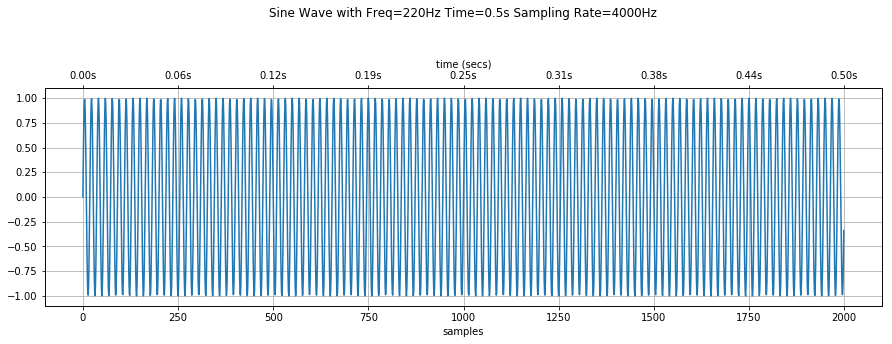

In [11]:
total_time_in_secs = 0.5

# Common sound sampling rates are 8000, 11025, 22050, 44100
# See: https://manual.audacityteam.org/man/sample_rates.html
sampling_rate = 4000

# Try changing the frequency here. What happens?
# What's the lowest sound your speakers can produce (or you can hear?)
# What's the highest frequency sound?
# What happens if this freq exceeds the sampling_rate?
# Recall the nyquist frequency: the highest freq we can produce is less than 1/2 * sampling_rate
freq = 220 # in Hz; 

# Create an array from 0 to total_time_in_secs * sampling_rate 
# But we need to divide each value in this array by our sampling_rate so that our time step (dt) is correct
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate

# Could also generate this signal by:
# time = np.linspace(0, total_time_in_secs, int(total_time_in_secs * sampling_rate), endpoint=False)

s = np.sin(2 * np.pi * freq * time)

fig, ax = plt.subplots(figsize=(15,4))
plot_signal_to_axes(ax, s, sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(freq, total_time_in_secs, sampling_rate))

ipd.Audio(s, rate=sampling_rate) # load a NumPy array

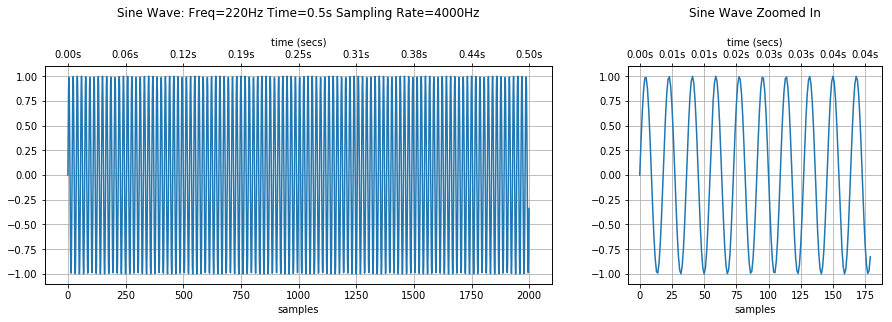

In [4]:
# Show the full waveform next to a zoomed in view
n_rows = 1
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]})
plot_signal_to_axes(axes[0], s, sampling_rate, 'Sine Wave: Freq={}Hz Time={}s Sampling Rate={}Hz'.
                    format(freq, total_time_in_secs, sampling_rate))

# show a zoomed in view of ~10 periods
num_periods_to_show = 10
plot_signal_to_axes(axes[1], s[0: int(sampling_rate/freq)*num_periods_to_show], 
                    sampling_rate, 'Sine Wave Zoomed In')
ipd.Audio(s, rate=sampling_rate) # load a NumPy array

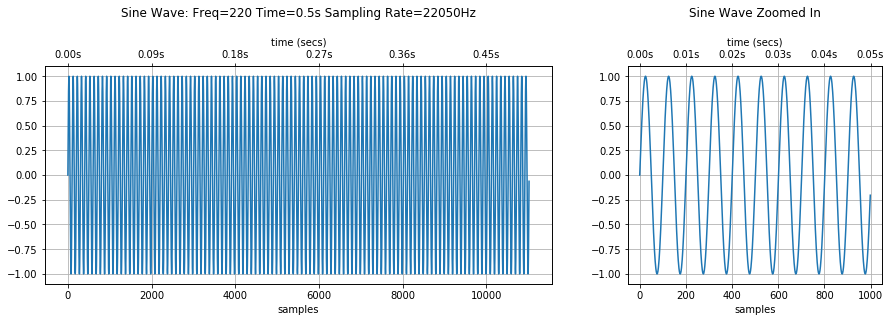

In [5]:
# Higher sampling rate
sampling_rate = 22050

time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
s = np.sin(2 * np.pi * freq * time)

fig, axes = plt.subplots(1, 2, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]})
plot_signal_to_axes(axes[0], s, sampling_rate, 'Sine Wave: Freq={} Time={}s Sampling Rate={}Hz'.
                    format(freq, total_time_in_secs, sampling_rate))

# show a zoomed in view of ~10 periods
num_periods_to_show = 10
plot_signal_to_axes(axes[1], s[0: int(sampling_rate/freq)*num_periods_to_show], 
                    sampling_rate, 'Sine Wave Zoomed In')
ipd.Audio(s, rate=sampling_rate) # load a NumPy array

# Signal Comparisons

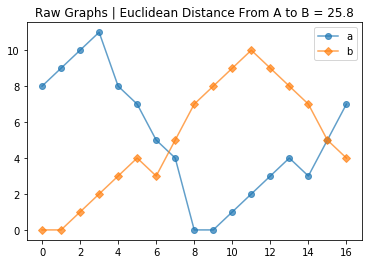

In [6]:
# Use Euclidean distance to compare two signals
from scipy import signal
from scipy.spatial import distance

a = [8, 9, 10, 11, 8, 7, 5, 4, 0, 0, 1, 2, 3, 4, 3, 5, 7]
b = [0, 0, 1, 2, 3, 4, 3, 5, 7, 8, 9, 10, 9, 8, 7, 5, 4]

euclid_distance_a_to_b = distance.euclidean(a, b)

fig, axes = plt.subplots()

axes.plot(a, alpha=0.7, label="a", marker="o")
axes.plot(b, alpha=0.7, label="b", marker="D")
axes.legend()
axes.set_title("Raw Graphs | Euclidean Distance From A to B = {:0.1f}".format(euclid_distance_a_to_b))
print()

Best correlation point=8, euclidean distance a to b=25.768197453450252, euclidean distance a_shifted to b=2.0



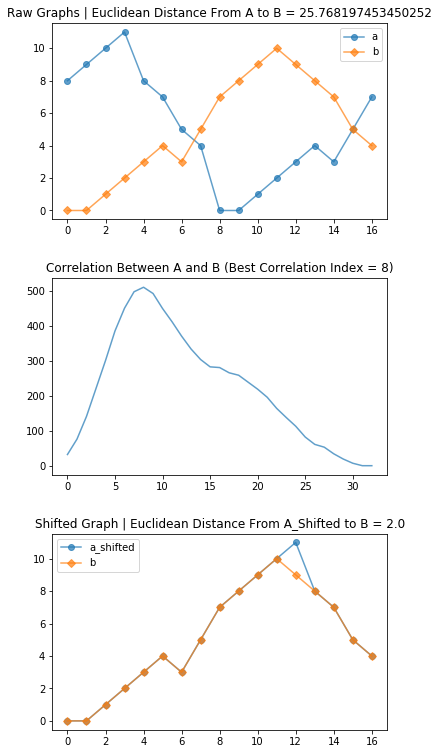

In [7]:
# Now let's use correlation to align the signals before comparison
corr_result_ab = signal.correlate(a,b)
best_correlation_point = np.argmax(corr_result_ab)
index_shift = len(a) - np.argmax(corr_result_ab)
a_shifted = np.roll(a, index_shift)

euclid_distance_a_to_b = distance.euclidean(a, b)
euclid_distance_ashifted_to_b = distance.euclidean(a_shifted, b)
print("Best correlation point={}, euclidean distance a to b={}, euclidean distance a_shifted to b={}"
      .format(best_correlation_point, euclid_distance_a_to_b, euclid_distance_ashifted_to_b))

fig, axes = plt.subplots(3, figsize=(6, 13))
fig.subplots_adjust(hspace=0.3)

axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title("Raw Graphs | Euclidean Distance From A to B = {}".format(euclid_distance_a_to_b))

# Note that the correlation signal is the length of a + b but that's because
# of how correlation works: it slides the two signals across each other to compute the correlation
axes[1].plot(corr_result_ab, alpha=0.7)
axes[1].set_title("Correlation Between A and B (Best Correlation Index = {})".format(best_correlation_point))

axes[2].plot(a_shifted, alpha=0.7, label="a_shifted", marker="o")
axes[2].plot(b, alpha=0.7, label="b", marker="D")
axes[2].legend()
axes[2].set_title("Shifted Graph | Euclidean Distance From A_Shifted to B = {}".format(euclid_distance_ashifted_to_b))
print()

Best correlation point=169, euclidean distance a to b=12.165525060596439, euclidean distance a_shifted to b=1.973205017723358


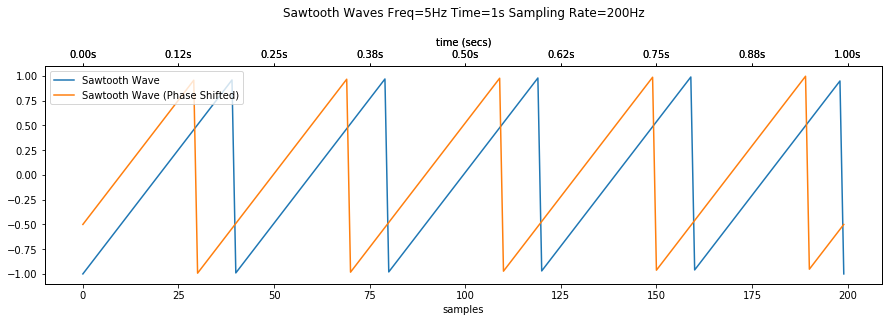

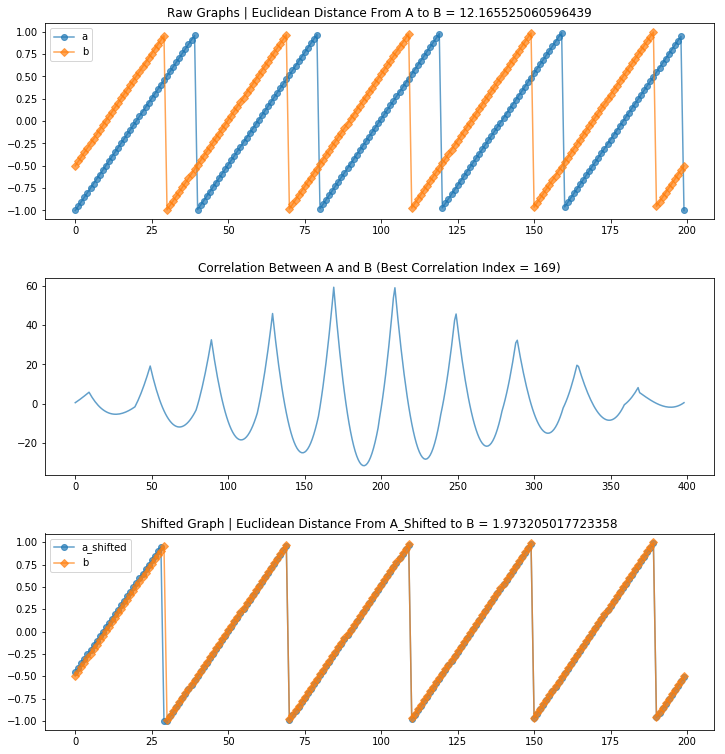

In [8]:
total_time_in_secs = 1
sampling_rate = 200
freq = 5

t = np.linspace(0, total_time_in_secs, sampling_rate)
sawtooth_a = signal.sawtooth(2 * np.pi * freq * t)
sawtooth_b = signal.sawtooth(2 * np.pi * freq * t + np.pi/2)
fig, ax = plt.subplots(figsize=(15,4))

title = 'Sawtooth Waves Freq={}Hz Time={}s Sampling Rate={}Hz'.\
          format(freq, total_time_in_secs, sampling_rate)
plot_signal_to_axes(ax, sawtooth_a, sampling_rate, title, "Sawtooth Wave")
plot_signal_to_axes(ax, sawtooth_b, sampling_rate, title, "Sawtooth Wave (Phase Shifted)")

plot_aligned_signal_comparisons(sawtooth_a, sawtooth_b)

Best correlation point=209, euclidean distance a to b=14.142135623730951, euclidean distance a_shifted to b=1.5211096026534148e-14


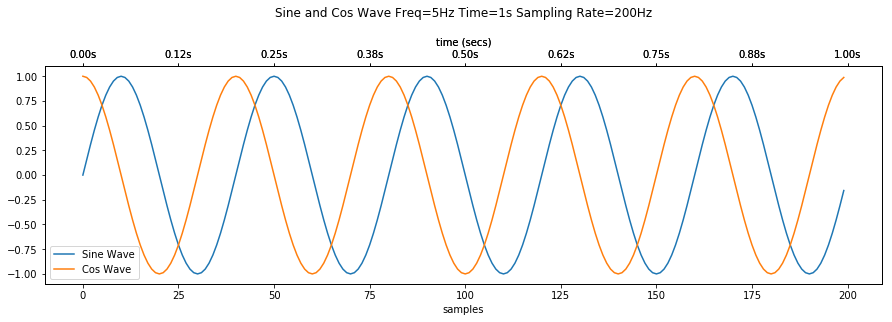

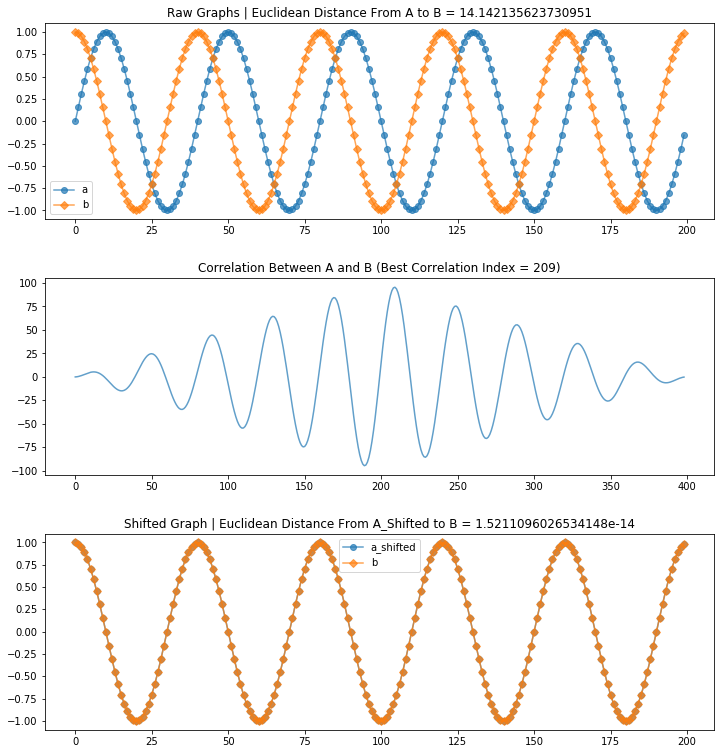

In [9]:
# Create and plot a simple sine and cos wave
total_time_in_secs = 1
sampling_rate = 200
freq = 5

sine_wave = create_sine_wave(freq, sampling_rate, total_time_in_secs)
cos_wave = create_cos_wave(freq, sampling_rate, total_time_in_secs)

fig, ax = plt.subplots(figsize=(15,4))
title = 'Sine and Cos Wave Freq={}Hz Time={}s Sampling Rate={}Hz'.\
          format(freq, total_time_in_secs, sampling_rate)

plot_signal_to_axes(ax, sine_wave, sampling_rate, title, "Sine Wave")
plot_signal_to_axes(ax, cos_wave, sampling_rate, title, "Cos Wave")

plot_aligned_signal_comparisons(sine_wave, cos_wave)

# Additive Synthesis

[17, 26, 34, 51, 67, 76, 84, 101, 117]


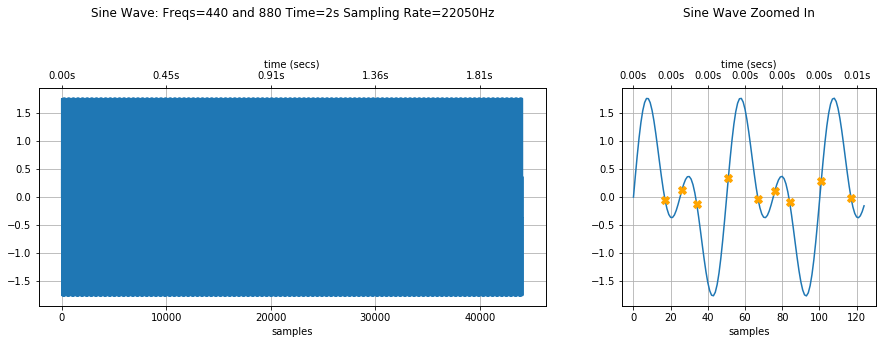

In [56]:
# Show additive nature of waves

total_time_in_secs = 2
sampling_rate = 22050

# Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
# rate to get each time_step)
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate

# Could also generate this signal by:
# time = np.linspace(0, total_time_in_secs, int(total_time_in_secs * sampling_rate), endpoint=False)
freq1 = 440
freq2 = 880
signal1 = np.sin(2 * np.pi * freq1 * time)
signal2 = np.sin(2 * np.pi * freq2 * time)
signal_combined = signal1 + signal2

n_rows = 1
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]})
plot_signal_to_axes(axes[0], signal_combined, sampling_rate, 'Sine Wave: Freqs={} and {} Time={}s Sampling Rate={}Hz'.
                    format(freq1, freq2, total_time_in_secs, sampling_rate))

# show a zoomed in view of ~10 periods
plot_signal_to_axes(axes[1], signal_combined[0: int(sampling_rate/freq2)*5], sampling_rate, 'Sine Wave Zoomed In')

# zero_crossings = calc_zero_crossings(signal_combined[0: int(sampling_rate/freq2)*5])
# print(zero_crossings)
# for zero_index in zero_crossings:
#     axes[1].plot(zero_index, signal_combined[zero_index], marker='X', markersize=8, color="orange")

ipd.Audio(signal_combined, rate=sampling_rate) # load a NumPy array

# Noise and Smoothing

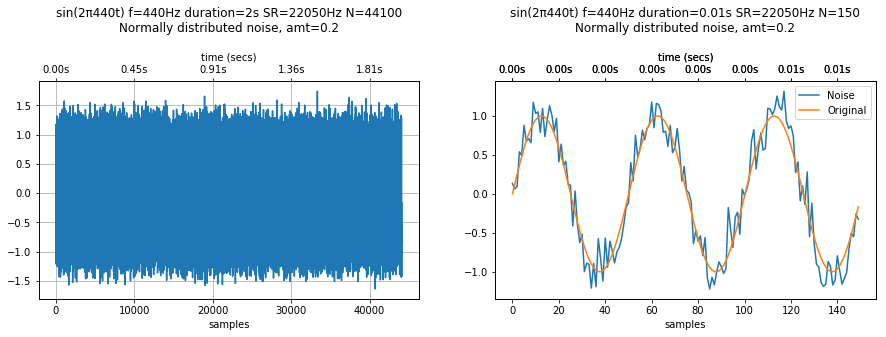

In [11]:
# Show addition of noise
total_time_in_secs = 2
freq = 440 # in Hz
sampling_rate = 22050

# Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
# rate to get each time_step)
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate

signal = np.sin(2 * np.pi * freq * time)

noise_amt = 0.2 # higher amount, higher noise
noise = np.random.normal(0,noise_amt,len(time))

signal_with_noise = signal + noise
n_rows = 1
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4))

title = "sin(2π{}t) f={}Hz duration={}s SR={}Hz N={}\nNormally distributed noise, amt={}".\
        format(freq, freq, total_time_in_secs, sampling_rate, len(signal), noise_amt)
plot_signal_to_axes(axes[0], signal_with_noise, sampling_rate, title)

# show a zoomed in view
zoomed_in_samples = int(sampling_rate/freq)*3
zoomed_in_time = zoomed_in_samples/sampling_rate
title_zoomed = "sin(2π{}t) f={}Hz duration={:.2f}s SR={}Hz N={}\nNormally distributed noise, amt={}".\
        format(freq, freq, zoomed_in_time, sampling_rate, zoomed_in_samples, noise_amt)
plot_signal_to_axes(axes[1], signal_with_noise[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label = "Noise")
plot_signal_to_axes(axes[1], signal[0: zoomed_in_samples], sampling_rate, signal_label = "Original")
ipd.Audio(signal_with_noise, rate=sampling_rate) # load a NumPy array

## Mean Filter

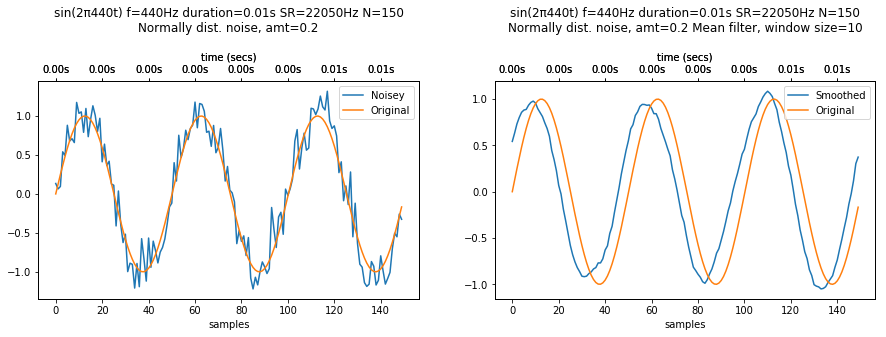

In [12]:
# shows how to apply a mean filter via convolution with a given window size
filter_window_size = 10
signal_smoothed_mean = np.convolve(signal_with_noise, np.ones((filter_window_size,))/filter_window_size, mode='valid') 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4))

# zoom in
num_periods_to_show = 3
zoomed_in_samples = int(sampling_rate/freq)*num_periods_to_show
zoomed_in_time = zoomed_in_samples/sampling_rate

title_zoomed = "sin(2π{}t) f={}Hz duration={:.2f}s SR={}Hz N={}\nNormally dist. noise, amt={}".\
        format(freq, freq, zoomed_in_time, sampling_rate, zoomed_in_samples, noise_amt)

title_zoomed_filtered = title_zoomed + " Mean filter, window size={}".format(filter_window_size)

plot_signal_to_axes(axes[0], signal_with_noise[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Noisey")
plot_signal_to_axes(axes[0], signal[0: zoomed_in_samples], sampling_rate, signal_label="Original")

plot_signal_to_axes(axes[1], signal_smoothed_mean[0: zoomed_in_samples], sampling_rate, title_zoomed_filtered, signal_label="Smoothed")
plot_signal_to_axes(axes[1], signal[0: zoomed_in_samples], sampling_rate, title_zoomed_filtered, signal_label="Original")
ipd.Audio(signal_smoothed_mean, rate=sampling_rate) 

## Median Filter

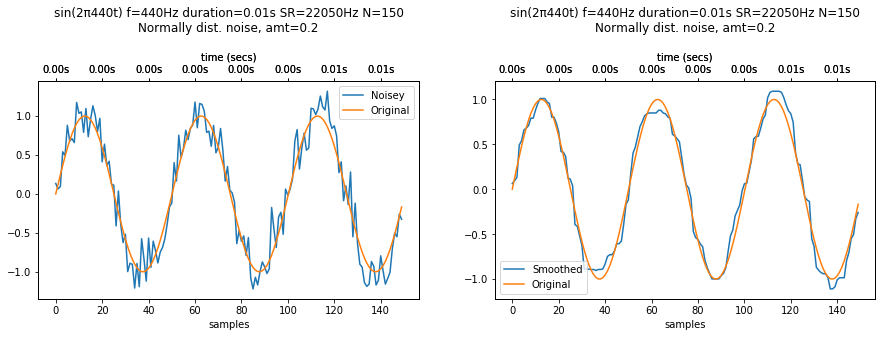

In [13]:
# Shows how to apply a median filter using scipy
filter_window_size = 11 # needs to be odd sized
signal_smoothed_median = sp.signal.medfilt(signal_with_noise, filter_window_size)

# plot zoomed in view
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4))
num_periods_to_show = 3
zoomed_in_samples = int(sampling_rate/freq)*num_periods_to_show
zoomed_in_time = zoomed_in_samples/sampling_rate

title_zoomed = "sin(2π{}t) f={}Hz duration={:.2f}s SR={}Hz N={}\nNormally dist. noise, amt={}".\
        format(freq, freq, zoomed_in_time, sampling_rate, zoomed_in_samples, noise_amt)
title_zoomed_filtered = title_zoomed + " Median filter, window size={}".format(filter_window_size)

plot_signal_to_axes(axes[0], signal_with_noise[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Noisey")
plot_signal_to_axes(axes[0], signal[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Original")

plot_signal_to_axes(axes[1], signal_smoothed_median[0: zoomed_in_samples], sampling_rate, title_zoomed_filtered, signal_label="Smoothed")
plot_signal_to_axes(axes[1], signal[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Original")

ipd.Audio(signal_smoothed_median, rate=sampling_rate) 

## Savgov Filter

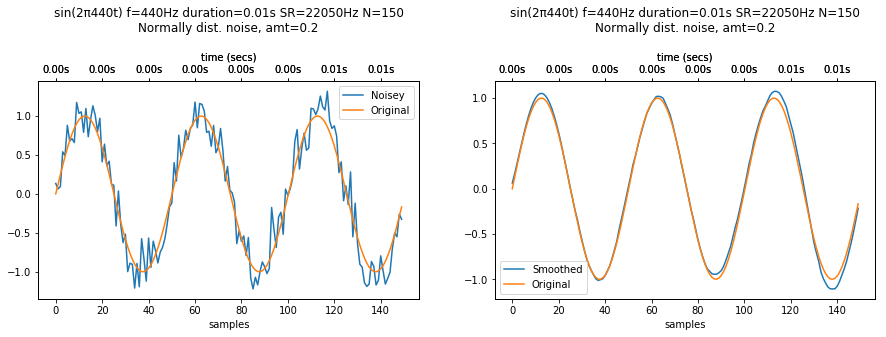

In [14]:
# from scipy.signal import savgol_filter
filter_window_size = 51
signal_smoothed_savgov = sp.signal.savgol_filter(signal_with_noise, filter_window_size, 5)

# plot zoomed in view
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4))
num_periods_to_show = 3
zoomed_in_samples = int(sampling_rate/freq)*num_periods_to_show
zoomed_in_time = zoomed_in_samples/sampling_rate

title_zoomed = "sin(2π{}t) f={}Hz duration={:.2f}s SR={}Hz N={}\nNormally dist. noise, amt={}".\
        format(freq, freq, zoomed_in_time, sampling_rate, zoomed_in_samples, noise_amt)
title_zoomed_filtered = title_zoomed + " Savgol filter, window size={}".format(filter_window_size)

plot_signal_to_axes(axes[0], signal_with_noise[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Noisey")
plot_signal_to_axes(axes[0], signal[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Original")

plot_signal_to_axes(axes[1], signal_smoothed_savgov[0: zoomed_in_samples], sampling_rate, title_zoomed_filtered, signal_label="Smoothed")
plot_signal_to_axes(axes[1], signal[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Original")

ipd.Audio(signal_smoothed_savgov, rate=sampling_rate) 

# FFT
A Fast Fourier Transform (FFT) samples a signal and extracts the frequency components. It is used to transform a signal from the time-domain to the frequency-domain.
![Time vs. Frequency view of signal](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png "View of a signal in the time and frequency domain") 

For example, the signal below consists of a sum of cosine waves at 10, 20, 30, 40, and 50 Hz.
![FFT of an example signal](https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/FFT_of_Cosine_Summation_Function.png/800px-FFT_of_Cosine_Summation_Function.png)

Text(0,0.5,'|Y(freq)|')

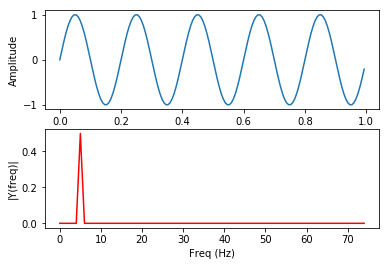

In [43]:
import matplotlib.pyplot as plt
import numpy as np
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

Fs = 150.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

ff = 5;   # frequency of the signal
y = np.sin(2*np.pi*ff*t)

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(int(n/2))]

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')


max freq:  220.0


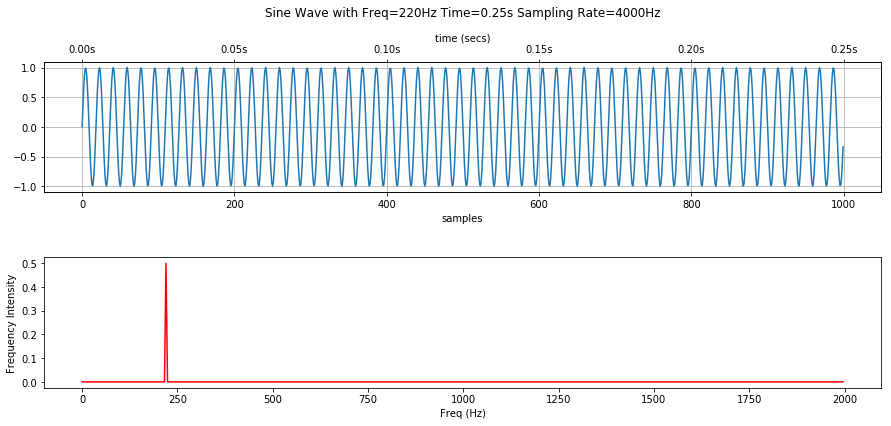

In [6]:
total_time_in_secs = 0.25
sampling_rate = 4000
freq = 220 # in Hz; 

# Create an array from 0 to total_time_in_secs * sampling_rate 
# But we need to divide each value in this array by our sampling_rate so that our time step (dt) is correct
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
s = np.sin(2 * np.pi * freq * time)

fig, axes = plt.subplots(2, 1, figsize=(15,6))
fig.subplots_adjust(hspace=0.5)
plot_signal_to_axes(axes[0], s, sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(freq, total_time_in_secs, sampling_rate))

# analyze this signal
n = len(s)
fft = np.fft.fft(s)
freqs = np.fft.fftfreq(n)
freqs = freqs * sampling_rate # convert normalized freq bins to our freq bins

freqs = freqs[range(n//2)] # one side freq range
fft = np.abs(fft)[range(n//2)] # one side freq range
fft = fft / n # normalize to values 0 - 1
axes[1].plot(freqs, fft, 'r')
axes[1].set_xlabel('Freq (Hz)')
axes[1].set_ylabel('Frequency Intensity')

# find the max frequency
idx = np.argmax(np.abs(fft))
freq = freqs[idx]
print("max freq: ", freq)

ipd.Audio(s, rate=sampling_rate)

max freq: 200.0 with coef: 0.5000000000000014


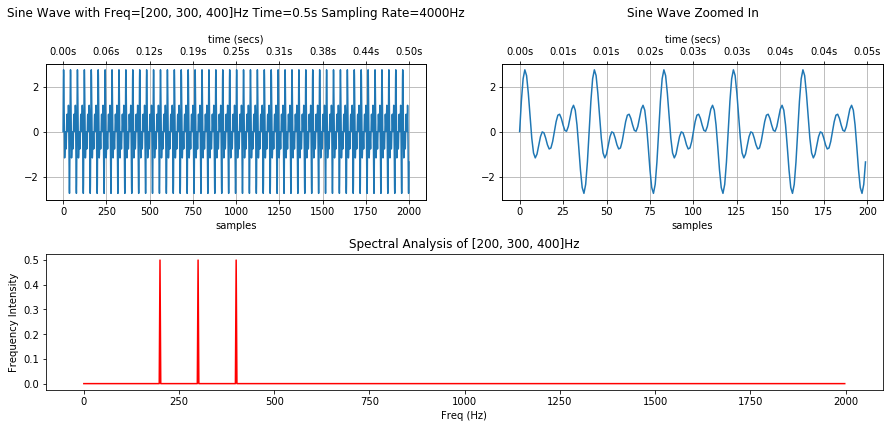

In [7]:
total_time_in_secs = 0.5
sampling_rate = 4000
input_freqs = [200, 300, 400]
# freqs = [523.25, 659.25, 783.99] # c chord

# Create an array from 0 to total_time_in_secs * sampling_rate 
# But we need to divide each value in this array by our sampling_rate so that our time step (dt) is correct
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
s = np.zeros(len(time))
for freq in input_freqs:
    a = np.sin(2 * np.pi * freq * time)
    s += a
    
# create figure
plt.figure(figsize=(15, 6))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.subplots_adjust(hspace=0.4)

plot_signal_to_axes(ax1, s, sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(input_freqs, total_time_in_secs, sampling_rate))

plot_signal_to_axes(ax2, s[0: sampling_rate // 20], sampling_rate, 'Sine Wave Zoomed In')

# analyze this signal
n = len(s)
fft = np.fft.fft(s)
freqs = np.fft.fftfreq(n)
freqs = freqs * sampling_rate # convert normalized freq bins to our freq bins

freqs = freqs[range(n//2)] # one side freq range
fft = np.abs(fft)[range(n//2)] # one side freq range
fft = fft / n # normalize to values 0 - 1
ax3.plot(freqs, fft, 'r')
ax3.set_title('Spectral Analysis of {}Hz'.format(input_freqs))
ax3.set_xlabel('Freq (Hz)')
ax3.set_ylabel('Frequency Intensity')

# find the max frequency
idx = np.argmax(np.abs(fft))
freq_at_max_intensity = freqs[idx]
print("max freq: {} with coef: {}".format(freq_at_max_intensity, fft[idx]))

ipd.Audio(s, rate=sampling_rate)

In [15]:
# Concatate waves to make a scale and then analyze waveform using ffts
c_scale = [261.626, 293.665, 329.628, 349.228, 391.995, 440, 493.883, 523.251] # c scale starting with middle c at 261.626
total_time_per_note_in_secs = 1
sampling_rate = 11025

signal_combined = np.array([])
map_freq_to_signal = dict()
for freq_of_note in c_scale:
    # TODO: currently this concatenation is not smooth; need to align better based on period
    # You can hear the 'pop' of the sound when it transitions notes and can see it in the spectrogram below
    signal_for_note = create_sine_wave(freq_of_note, sampling_rate, total_time_per_note_in_secs)
    map_freq_to_signal[freq_of_note] = signal_for_note
    signal_combined = np.concatenate((signal_combined, signal_for_note))
    
# plot_multiple_freq(c_scale, signal_combined, map_freq_to_signal, sampling_rate)

ipd.Audio(signal_combined, rate=sampling_rate) 

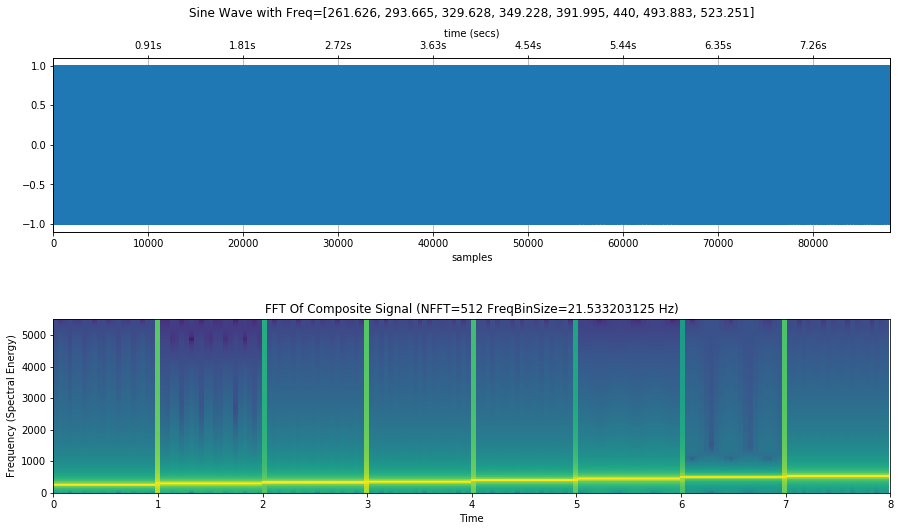

In [16]:
# Frequency analysis
fig, axes = plt.subplots(2, 1, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)
freqs = c_scale

axes[0].set_xlim(xmin=0,xmax=total_time_per_note_in_secs * len(freqs) * sampling_rate)
plot_signal_to_axes(axes[0], signal_combined, sampling_rate, 'Sine Wave with Freq={}'.format(freqs))

# NFFT is the num of points from sample used to calculate the FFT. Must be greater than 1/2 sampling rate
# noverlap is the num of overlapping points between NFFT windows

# You can calculate your frequency resolution (that is the size of each frequency bin)
# by FreqResolution = SamplingRate / FFTWindowSize
fft_window_size = 512
axes[1].specgram(signal_combined, NFFT=fft_window_size, Fs=sampling_rate, noverlap=0)
axes[1].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", 
            title='FFT Of Composite Signal (NFFT={} FreqBinSize={} Hz)'.
            format(fft_window_size, sampling_rate/fft_window_size))
# axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_xlim(xmin=0, xmax=total_time_per_note_in_secs * len(freqs))
print()

# Peak Detection

A great writeup about finding peaks using scipy [here](https://blog.ytotech.com/2015/11/01/findpeaks-in-python/) and [here](https://github.com/MonsieurV/py-findpeaks). While there are a number of different approaches/algorithms to try, the consensus seems to be that `scipy.signal.find_peaks` performs reliably well; however, this wasn't released until `scipy 1.1.0`. To determine what version you have installed, type `print(scipy.__version__)` in a cell.

In [14]:
import scipy
print(scipy.__version__)

1.2.1


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1 ]
32 [1.6] [0.9995736]


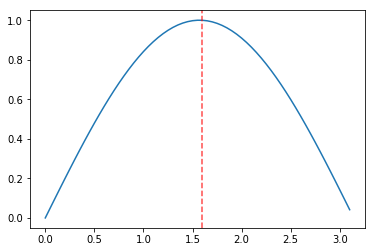

In [28]:
# See: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.find_peaks_cwt.html
# signal.find_peaks_cwt from https://academic.oup.com/bioinformatics/article/22/17/2059/274284
xs = np.arange(0, np.pi, 0.05)
print(xs)
data = np.sin(xs)
plt.plot(xs, data)
peak_idx = signal.find_peaks_cwt(data, np.arange(1,10))
print(peak_idx[0], xs[peak_idx], data[peak_idx])
plt.axvline(x=xs[peak_idx], color='r', linestyle='--', alpha=0.7)

[  3  39  50  53  79 112 140 171 194] [22.68457068]


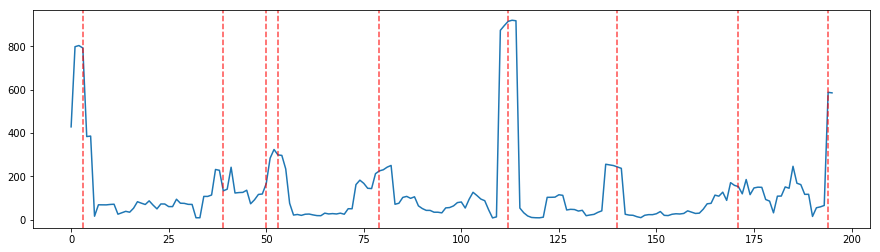

In [18]:
# Peak detection using find_peaks_cwt
mu, sigma = 3., 2.
length = 200
s = np.random.lognormal(mu, sigma, length)

filter_window_size = 5
s_smoothed = np.convolve(s, np.ones((filter_window_size,))/filter_window_size, mode='valid') 

plt.figure(figsize=(15, 4))
plt.plot(s_smoothed)

peak_indices = signal.find_peaks_cwt(s_smoothed, np.arange(5,10))
print(peak_indices, s[peak_idx])

for peak_index in peak_indices:
    plt.axvline(x=peak_index, color='r', linestyle='--', alpha=0.7)

Detect peaks with minimum height and distance filters.
[ 2 22] [25 20]


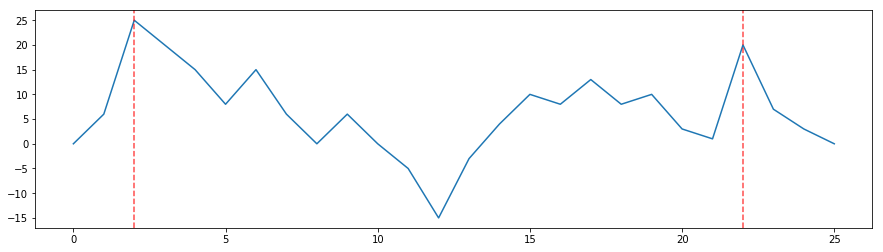

In [54]:
# Sample modified from https://github.com/MonsieurV/py-findpeaks#scipysignalfind_peaks
import numpy as np
import scipy.signal
s = np.array([0, 6, 25, 20, 15, 8, 15, 6, 0, 6, 0, -5, -15, -3, 4, 10, 8,
                   13, 8, 10, 3, 1, 20, 7, 3, 0])
print('Detect peaks with minimum height and distance filters.')

# change height to see different behavior
peak_indices, peak_properties = scipy.signal.find_peaks(s, height=20, distance=2.1)
print(peak_indices, s[peak_indices])

plt.figure(figsize=(15, 4))
plt.plot(s)

for peak_index in peak_indices:
    plt.axvline(x=peak_index, color='r', linestyle='--', alpha=0.7)

[ 2 22] [25 20]
[11, 14]


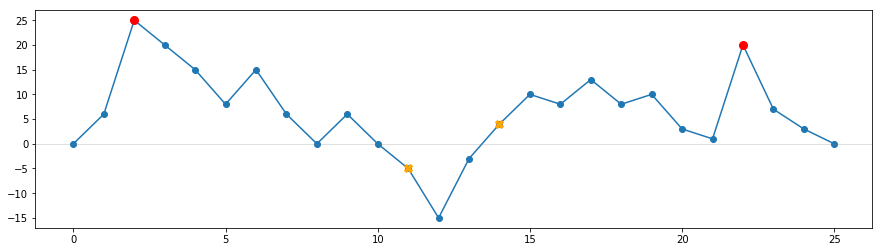

In [55]:
s = np.array([0, 6, 25, 20, 15, 8, 15, 6, 0, 6, 0, -5, -15, -3, 4, 10, 8,
                   13, 8, 10, 3, 1, 20, 7, 3, 0])

# change height to see different 
peak_indices, peak_properties = scipy.signal.find_peaks(s, height=20, distance=2.1)
print(peak_indices, s[peak_indices])

zero_crossings = calc_zero_crossings(s)
print(zero_crossings)

plt.figure(figsize=(15, 4))
plt.plot(s, marker='o')

for zero_index in zero_crossings:
    plt.plot(zero_index, s[zero_index], marker='X', markersize=8, color="orange")

for peak_index in peak_indices:
    plt.plot(peak_index, s[peak_index], marker='o', markersize=8, color="red")

plt.axhline(y=0, color='gray', alpha=0.5, linewidth=0.5)

# Sandbox
Everything below here is just a sandbox for me to play.

[0.00000000e+00 1.95312500e-03 3.90625000e-03 ... 4.99414062e+00
 4.99609375e+00 4.99804688e+00]


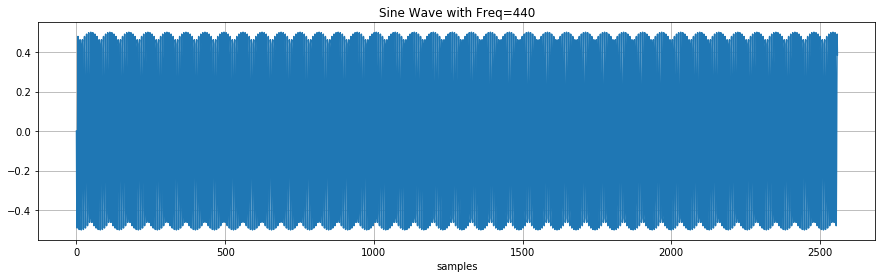

In [17]:
# Sample from: https://musicinformationretrieval.com/ipython_audio.html
import IPython.display as ipd

sr = 512 # sample rate 22050
T = 5.0    # seconds
freq = 440
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
print(t)
x = 0.5*np.sin(2*np.pi*freq*t)                # pure sine wave at 440 Hz

fig, ax = plt.subplots(figsize=(15,4))
ax.plot(x)
ax.set(xlabel='samples', title='Sine Wave with Freq={}'.format(freq))
ax.grid()

ipd.Audio(x, rate=sr) # load a NumPy array

# Outline
- Filtering
- FFT
  - Show how to calculate and use (maybe draw bar graph)
- Cross correlation
- Signal comparisons
  - show a few simple examples, including sin and cos (which are phase shifted)

## Ideas:
- Use audio as primary signal. You can play audio within Jupyter notebook https://musicinformationretrieval.com/ipython_audio.html
- Show effect of smoothing, etc.
- Show effects like reverb?

## Lecture Ideas for Future
- Go over cross-correlation algorithm (e.g., https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html)
- Go over convolution algorithm and how it can be used for filtering